# Classification of Alzhaimer through Brain MRI

## Importing Libraries

In [1]:
#Package imports.
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random
import tensorflow as tf
from keras.utils import to_categorical
from keras import layers,models,losses
from sklearn import model_selection, metrics, preprocessing
from skimage.metrics import structural_similarity as ssim

In [2]:
#Import and mount Google Drive.
from google.colab import drive
#
drive.mount("/content/drive")

Mounted at /content/drive


## Load Images

In [3]:
#Unzip the dataset file and store it in a folder called images.
#!unzip "/content/drive/MyDrive/MRI.zip" -d "/content/drive/MyDrive/images_MRI/"

In [4]:
!ls "/content/drive/MyDrive/images_MRI/Data"

'Mild Dementia'  'Moderate Dementia'  'Non Demented'  'Very mild Dementia'


In [5]:
#Read the images and get the data in a RGB and specific shape
folder_path = "/content/drive/MyDrive/images_MRI/Data/"
size = 128
data = []
labels = []
paths=[]
for folder in os.listdir(folder_path):
    for files in os.listdir(os.path.join(folder_path, folder)):
        if files.endswith("jpg"):
            labels.append(folder)
            #Create the image path.
            img_path = os.path.join(folder_path, folder, files)
            #Read in the images.
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            #Change BGR colour default from cv2 to RGB used in matplotlib.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #Resize the images.
            img = cv2.resize(img, (size, size))
            data.append(img)
            paths.append(img_path)

#Convert the data from a list to a NumPy array.
data_arr = np.array(data)

## Select by random sampling

In [6]:
#labels_np=np.array(labels)
#selected_indices={}
#for t in ['Mild Dementia','Non Demented','Very mild Dementia']:
#  selected_indices[t]=np.random.choice(np.where(labels_np==t)[0],500,replace=False)
#all_indices=np.hstack((selected_indices['Mild Dementia'],selected_indices['Non Demented'],selected_indices['Very mild Dementia'],np.where(labels_np=='Moderate Dementia')[0]))
#paths_to_delete=np.setdiff1d(np.array(paths),np.array(paths)[all_indices])
#for n in paths_to_delete:
#  os.remove(n)

## Data Analysis

In [7]:
#Check the size of the images
data_arr.shape

(1988, 128, 128, 3)

In [8]:
#Check all the classes
set(labels)

{'Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia'}

In [9]:
#Checking number of images from Mild Dementia
print('Mild Dementia:',labels.count("Mild Dementia"))
#Checking number of images from Moderate Dementia
print('Moderate Dementia:',labels.count("Moderate Dementia"))
#Checking number of images from Non Demented
print('Non Demented:',labels.count("Non Demented"))
#Checking number of images from Very mild Dementia
print('Very mild Dementia:',labels.count("Very mild Dementia"))

Mild Dementia: 500
Moderate Dementia: 488
Non Demented: 500
Very mild Dementia: 500


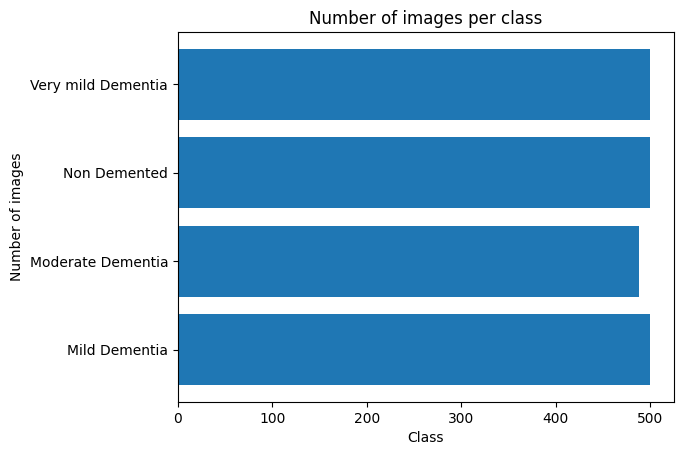

In [10]:
#Plotting horizontal barchart of the classes and images.
labels_plt=['Mild Dementia','Moderate Dementia','Non Demented','Very mild Dementia']
count=[labels.count('Mild Dementia'),labels.count('Moderate Dementia'),labels.count('Non Demented'),labels.count('Very mild Dementia')]
fig,ax=plt.subplots()
ax.barh(labels_plt,count)
ax.set_title('Number of images per class')
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
plt.show()

(-0.5, 127.5, 127.5, -0.5)

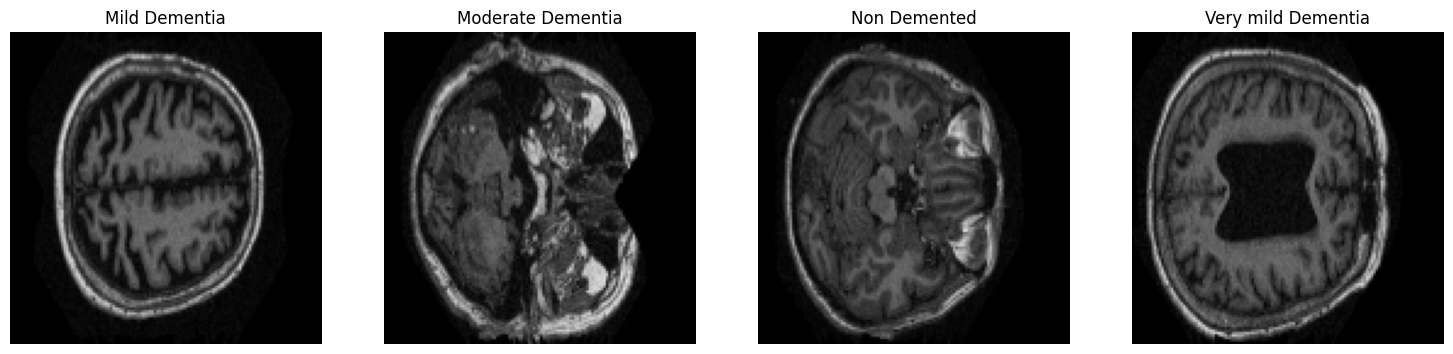

In [11]:
#Plot of examples by class of image
fig,ax=plt.subplots(1,4)
fig.set_size_inches(18.5, 10.5)
ax[0].imshow(data_arr[np.random.choice(range(1,500),1)[0]])
ax[0].set_title('Mild Dementia')
ax[0].axis('off')
ax[1].imshow(data_arr[np.random.choice(range(501,1000),1)[0]])
ax[1].set_title('Moderate Dementia')
ax[1].axis('off')
ax[2].imshow(data_arr[np.random.choice(range(1001,1500),1)[0]])
ax[2].set_title('Non Demented')
ax[2].axis('off')
ax[3].imshow(data_arr[np.random.choice(range(1501,1993),1)[0]])
ax[3].set_title('Very mild Dementia')
ax[3].axis('off')

## Preprocessing

### Create noise and data augmentation

In [71]:
#Function for create noise in the image.
def image_noise(image, noise_level):
    image = tf.cast(image, tf.int32)
    height, width, channels = image.shape[0], image.shape[1], image.shape[2]
    pixels_total = height * width * channels
    noise_added = pixels_total * noise_level
    noise_total=0
    #Get the percentage of noise
    while noise_total<noise_added:
      w=random.randint(1,3)
      h=random.randint(1,3)
      x=random.randint(1,width-w)
      y=random.randint(1,height-h)
      noise_total += w*h
      noise_to_add=w*h*3
      #Create the indices for introduce noise
      indices = [[j, k, i] for i in range(3) for j
                 in range(y, y + h) for k in range(x, x + w)]
      #Generate black noise
      noise_values = [np.random.randint(1,25)]*noise_to_add
      #Introduce noise
      image = tf.tensor_scatter_nd_update(image, indices, noise_values)
    return image

In [72]:
#Function for augment the images
def image_augment(image,seed):
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    #Random left flip
    image = tf.image.stateless_random_flip_left_right(
       image, seed)
    #Random brightness change
    #image = tf.image.stateless_random_brightness(
       # image, max_delta=0.1, seed=new_seed)
    #Introduce hue
    #image = tf.image.stateless_random_hue(
       # image, 0.2, seed)
    #Introduce saturation
    #image = tf.image.stateless_random_saturation(
        #image, 0.3, 1.0, seed)
    #Adjust any value to the RGB range
    image = tf.clip_by_value(image, 0, 255)
    return image

In [73]:
#Set the random seed generator
rng = tf.random.Generator.from_seed(123, alg='philox')

In [74]:
#Function to prepare the images with noise and augmentation
def image_wrapper(image):
  #Generate random independent seed
  seed=rng.make_seeds(2)[0]
  #Augment data with the random seed
  image1=image_augment(image,seed)
  #Add noise
  image2=image_noise(image1,0.1)
  return image2/255,image1/255

In [75]:
#Mean squared error between 2 images
def mse(image1,image2):
  mse=np.mean((image1.astype('float')-image2.astype('float'))**2)
  return mse

In [76]:
#Mean squared error between 2 groups of images
def mse_mean(image1,image2):
  mse_values=[]
  for n in range(0,image1.shape[0]):
      mse_value = mse(image1[n],image2[n])
      mse_values.append(mse_value)

  mse_mean = np.mean(mse_values)
  return mse_mean

In [77]:
#Peak signal to noise ratio between two groups of images
def psnr_mean(image1,image2):
  psnr_values=[]
  for n in range(0,image1.shape[0]):
    mse1=mse(image1[n],image2[n])
    psnr=20*np.log10(1/np.sqrt(mse1))
    psnr_values.append(psnr)
  psnr_mean = np.mean(psnr_values)
  return psnr_mean

In [78]:
#Structural similarity index between two images
def ssim_mean(image1,image2):
  ssim_values=[]
  for n in range(0,image1.shape[0]):
      ssim_value = ssim(image1[n],image2[n],channel_axis=2,data_range=image1[n].max()-image1[n].min())
      ssim_values.append(ssim_value)
  ssim_mean = np.mean(ssim_values)
  return ssim_mean

In [79]:
#Get dataset tensorflow type
data=tf.data.Dataset.from_tensor_slices(data_arr)

In [80]:
#Split train and test
data_train,data_test=model_selection.train_test_split(data_arr, test_size=0.2, random_state=42)
data_train,data_validation=model_selection.train_test_split(data_train, test_size=0.2, random_state=42)

In [81]:
#Preprocess the data
data_train_processed=tf.data.Dataset.from_tensor_slices(data_train).shuffle(100).map(image_wrapper).batch(32)

In [ ]:
data_validation_noise=np.array([image_noise(x,0.1) for x in data_validation])
data_validation_processed=tf.data.Dataset.from_tensor_slices((data_validation_noise/255,data_validation/255)).batch(32)

data_test_noise=np.array([image_noise(x,0.1) for x in data_test])
data_test_processed=tf.data.Dataset.from_tensor_slices((data_test_noise/255,data_test/255)).batch(32)

In [ ]:
#Get data preprocessed
data_test_processed

In [ ]:
#Examples of
for item in data_train_processed.take(1):
    fig,ax=plt.subplots(1,2)
    fig.set_size_inches(10.5, 7.5)
    ax[0].imshow(item[0][0].numpy())
    ax[0].set_title('Augmented-Noised')
    ax[0].axis('off')
    ax[1].imshow(item[1][0].numpy())
    ax[1].set_title('Original')
    ax[1].axis('off')

In [ ]:
test_original = np.asarray(list(data_test_processed.unbatch().map(lambda x, y: y)))

## Denoising

In [27]:
single_test_original=np.expand_dims(data_arr[1]/255,axis=0)
single_test_noise=np.expand_dims(image_noise(data_arr[1],0.07).numpy()/255,axis=0)

### Autoencoder

In [28]:
#Basic auto encoder for denoising
#Encoder 1Conv + BatchNorm + MaxPooling
def encoder(filters):
    def apply(x):
        x=layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x=layers.BatchNormalization()(x)
        x=layers.MaxPooling2D((2,2),padding='same')(x)
        return x
    return apply

In [29]:
#Decoder 1ConvTrans + BatchNorm
def decoder(filters):
    def apply(x):
        x=layers.Conv2DTranspose(filters, (3,3), strides=2, padding='same', activation='relu')(x)
        x=layers.BatchNormalization()(x)
        return x
    return apply

In [30]:
#Auto Encoder 3Encoder + 3Decoder from 3 to 128
def autoencoder(input_shape=(128, 128, 3)):
    inputs=layers.Input(shape=input_shape)
    #Encoder
    x=encoder(32)(inputs)
    x=encoder(64)(x)
    x=encoder(128)(x)
    #Decoder
    x=decoder(128)(x)
    x=decoder(64)(x)
    x=decoder(32)(x)
    outputs=layers.Conv2D(3, (1,1), activation='sigmoid')(x)
    return models.Model(inputs, outputs)

In [31]:
#Define autoencoder and see the structure
ae=autoencoder()
ae.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 3)         │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 334,979 (1.28 MB)

 Trainable params: 334,083 (1.27 MB)

 Non-trainable params: 896 (3.50 KB)

In [32]:
#Compile model with adam and mean squared error
ae.compile(optimizer='adam',loss='mse')

In [33]:
ae_history=ae.fit(data_train_processed,epochs=10,validation_data=data_validation_processed)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 580ms/step - loss: 0.1187 - val_loss: 0.0766
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 375ms/step - loss: 0.0514 - val_loss: 0.0374
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 382ms/step - loss: 0.0304 - val_loss: 0.0296
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 380ms/step - loss: 0.0192 - val_loss: 0.0307
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 375ms/step - loss: 0.0124 - val_loss: 0.0309
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 388ms/step - loss: 0.0087 - val_loss: 0.0280
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 375ms/step - loss: 0.0067 - val_loss: 0.0245
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 390ms/step - loss: 0.0055 - val_loss: 0.0205
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - loss: 0.0047 - val_loss: 0.0160
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - loss: 0.0042 - val_loss: 0.0130


In [34]:
ae_prediction=ae.predict(single_test_noise)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(-0.5, 127.5, 127.5, -0.5)

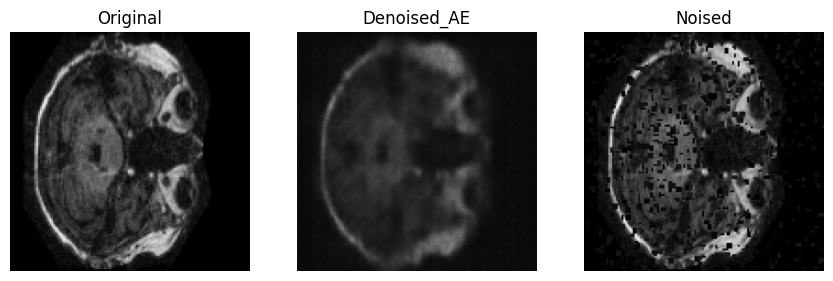

In [35]:

fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
#fig.suptitle('Auto Encoder denoising',fontsize=16)
ax[0].imshow(single_test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(ae_prediction[0])
ax[1].set_title('Denoised_AE')
ax[1].axis('off')
ax[2].imshow(single_test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')

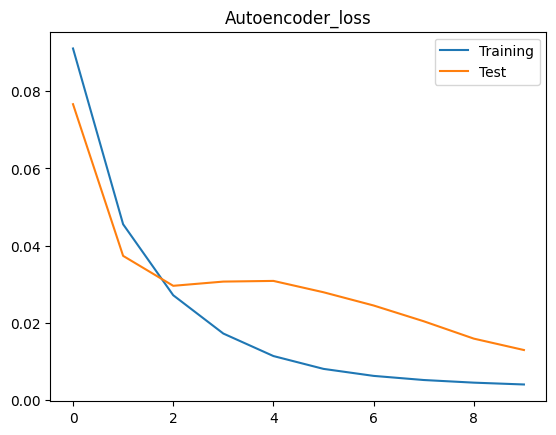

In [36]:
plt.plot(ae_history.history['loss'],label='Training')
plt.plot(ae_history.history['val_loss'],label='Test')
plt.title('Autoencoder_loss')
plt.legend()
plt.show()

In [37]:
ae_predicted=ae.predict(data_test_processed)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step


In [38]:
ae_mse=mse_mean(test_original,ae_predicted)
ae_psnr=psnr_mean(test_original,ae_predicted)
ae_ssim=ssim_mean(test_original,ae_predicted)
print('MSE:',round(ae_mse,3))
print('PSNR:',round(ae_psnr,3))
print('SSIM:',round(ae_ssim,3))

MSE: 0.013
PSNR: 67.159
SSIM: 0.349


### U-Net

In [39]:
#U-Net for denoising images
#DoubleConv 1Conv + 1BatchNorm + 1Conv + 1BatchNorm
def unet_double_conv(filters):
    def apply(x):
        x=layers.Conv2D(filters, (3,3),padding='same',activation='relu')(x)
        x=layers.BatchNormalization()(x)
        x=layers.Conv2D(filters, (3,3),padding='same',activation='relu')(x)
        x=layers.BatchNormalization()(x)
        return x
    return apply

In [40]:
#U-Net encoder 1MaxPooling + 1DoubleConv
def unet_encoder(filters):
    def apply(x):
        x=layers.MaxPooling2D((2,2))(x)
        x=unet_double_conv(filters)(x)
        return x
    return apply

In [41]:
#U-Net decoder 1ConvTrans + 1Concatenate +1DoubleConv
def unet_decoder(filters):
    def apply(x, skip):
        x=layers.Conv2DTranspose(filters,(3,3),activation='relu',strides=2,padding='same')(x)
        x=layers.Concatenate()([x, skip])
        x=unet_double_conv(filters)(x)
        return x
    return apply

In [42]:
#U-Net from 3 to 1024 with MaxPooling
def unet(input_shape=(128, 128, 3)):
    input = layers.Input(shape=input_shape)
    #Encoder from 3 to 1024
    x1 = unet_double_conv(64)(input)
    x2 = unet_encoder(128)(x1)
    x3 = unet_encoder(256)(x2)
    x4 = unet_encoder(512)(x3)
    x  = unet_encoder(1024)(x4)
    #Decoder feom 512 to 3
    x = unet_decoder(512)(x, x4)
    x = unet_decoder(256)(x, x3)
    x = unet_decoder(128)(x, x2)
    x = unet_decoder(64)(x, x1)
    output = layers.Conv2D(3,(1,1),activation='sigmoid')(x)
    return models.Model(input,output)

In [43]:
unet=unet()
unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 128, 128, 64)   │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 128, 128, 64)   │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 64, 64, 64)     │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 64, 64, 128)    │            512 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 64, 64, 128)    │            512 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 32, 32, 128)    │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 32, 32, 256)    │          1,024 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 32, 32, 256)    │          1,024 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 34,537,027 (131.75 MB)

 Trainable params: 34,525,251 (131.70 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [44]:
#Compile the unet with adam and mse
unet.compile(optimizer='adam',loss='mse')

In [45]:
#fit unet with train and validation sets
unet_history=unet.fit(data_train_processed,epochs=10,validation_data=data_validation_processed)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - loss: 0.0990 - val_loss: 0.0519
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 863ms/step - loss: 0.0301 - val_loss: 0.0389
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 832ms/step - loss: 0.0150 - val_loss: 0.0419
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 841ms/step - loss: 0.0089 - val_loss: 0.0484
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 859ms/step - loss: 0.0056 - val_loss: 0.0492
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 849ms/step - loss: 0.0039 - val_loss: 0.0481
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 833ms/step - loss: 0.0031 - val_loss: 0.0469
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 849ms/step - loss: 0.0024 - val_loss: 0.0433
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 833ms/step - loss: 0.0020 - val_loss: 0.0389
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 858ms/step - loss: 0.0017 - val_loss: 0.0328


In [46]:
#Predict a single test
unet_predicted=unet.predict(single_test_original)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


(-0.5, 127.5, 127.5, -0.5)

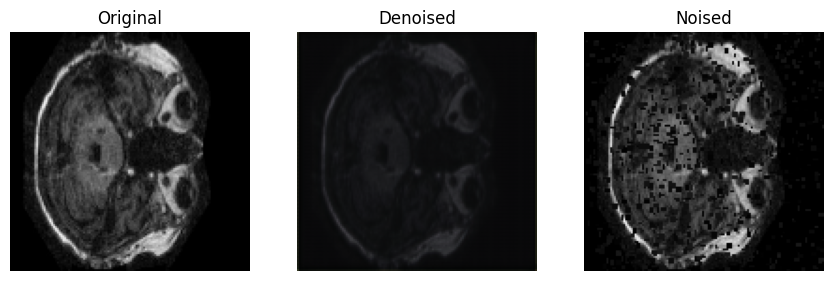

In [47]:
#Check the first results of the model
fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
ax[0].imshow(single_test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(unet_predicted[0])
ax[1].set_title('Denoised')
ax[1].axis('off')
ax[2].imshow(single_test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')

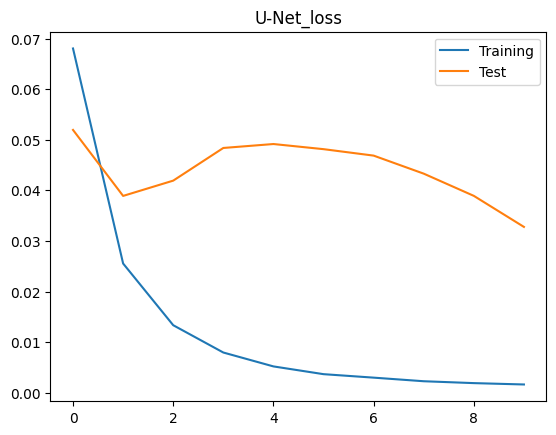

In [48]:
plt.plot(unet_history.history['loss'],label='Training')
plt.plot(unet_history.history['val_loss'],label='Test')
plt.title('U-Net_loss')
plt.legend()
plt.show()

In [49]:
unet_predicted=unet.predict(data_test_processed)

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


In [50]:
unet_mse=mse_mean(test_original,unet_predicted)
unet_psnr=psnr_mean(test_original,unet_predicted)
unet_ssim=ssim_mean(test_original,unet_predicted)
print('MSE:',round(unet_mse,3))
print('PSNR:',round(unet_psnr,3))
print('SSIM:',round(unet_ssim,3))

MSE: 0.032
PSNR: 63.18
SSIM: 0.208


### U-Net Residual (Upsampling)

In [51]:
def unet_conv_res(filters):
    def apply(x):
        conv = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        conv = layers.BatchNormalization()(conv)
        conv = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(conv)
        conv = layers.BatchNormalization()(conv)

        shortcut=layers.Conv2D(filters, (1,1), padding='same', activation='relu')(x)
        shortcut = layers.BatchNormalization()(shortcut)

        res = layers.Add()([shortcut, conv])
        res = layers.Activation('relu')(res)
        return res
    return apply

In [ ]:
#U-Net with updampling for denoising images
#DoubleConv 1Conv + 1BatchNorm + 1Conv + 1BatchNorm
def unet2_conv(filters):
    def apply(x):
        x = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        return x
    return apply

In [52]:
#Unet encoder with 1MaxPoolin and +1DoubleConv
def unet_encoder_res(filters):
    def apply(x):
        x = layers.MaxPooling2D((2,2))(x)
        x = unet_conv_res(filters)(x)
        return x
    return apply

In [53]:
#Unet decoder with 1Upsampling + 1ConvTrans +1Concat + 1DoubleConv
def unet_decoder_res(filters):
    def apply(x, skip):
        x = layers.UpSampling2D((2,2))(x)
        x = layers.Conv2DTranspose(filters, (1,1), activation='relu')(x)
        x = layers.Concatenate()([x, skip])
        x = unet_conv_res(filters)(x)
        return x
    return apply

In [54]:
#U-Net from 3 to 1024 with Upsampling
def unet_res(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)
    #Encoder from 3 to 1024
    x1 = unet_conv_res(64)(inputs)
    x2 = unet_encoder_res(128)(x1)
    x3 = unet_encoder_res(256)(x2)
    x4 = unet_encoder_res(512)(x3)
    x  = unet_encoder_res(1024)(x4)
    #Decoder from 512 to 3
    x = unet_decoder_res(512)(x, x4)
    x = unet_decoder_res(256)(x, x3)
    x = unet_decoder_res(128)(x, x2)
    x = unet_decoder_res(64)(x, x1)
    outputs = layers.Conv2D(3, (1,1), activation='sigmoid')(x)
    return models.Model(inputs, outputs)

In [55]:
#U-Net with Upsampling model with summary
unet_res = unet_res()
unet_res.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 128, 128, 64)   │            256 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 128, 128, 64)   │            256 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_26    │ (None, 128, 128, 64)   │            256 │ conv2d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_25    │ (None, 128, 128, 64)   │            256 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 128, 64)   │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 64)   │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 64, 64, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_27    │ (None, 64, 64, 128)    │            512 │ conv2d_26[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 64, 64, 128)    │          8,320 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_29    │ (None, 64, 64, 128)    │            512 │ conv2d_28[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2

 Total params: 30,374,019 (115.87 MB)

 Trainable params: 30,356,355 (115.80 MB)

 Non-trainable params: 17,664 (69.00 KB)

In [56]:
#U-Net with upsampling compile with adam and mse
unet_res.compile(optimizer='adam',loss='mse')

In [63]:
unet_res_history=unet_res.fit(data_train_processed,epochs=15,validation_data=data_validation_processed)

Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 860ms/step - loss: 9.8645e-04 - val_loss: 0.0155
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 836ms/step - loss: 9.3553e-04 - val_loss: 0.0113
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 859ms/step - loss: 9.0690e-04 - val_loss: 0.0090
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 839ms/step - loss: 8.3614e-04 - val_loss: 0.0070
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 834ms/step - loss: 8.2868e-04 - val_loss: 0.0048
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 840ms/step - loss: 7.9069e-04 - val_loss: 0.0032
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 842ms/step - loss: 7.8387e-04 - val_loss: 0.0020
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 852ms/step - loss: 7.6556e-04 - val_loss: 0.0932
Epoch 9/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 861ms/step - loss: 0.0039 - val_loss: 0.0514
Epoch 10/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 839ms/step - loss: 0.0015 - val_loss: 0.0573
Epoch 11/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 843ms/step - loss: 0.0012 - val_loss: 0.0349
Epoch 12/

In [64]:
single_unet_res_predicted=unet_res.predict(single_test_original)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


(-0.5, 127.5, 127.5, -0.5)

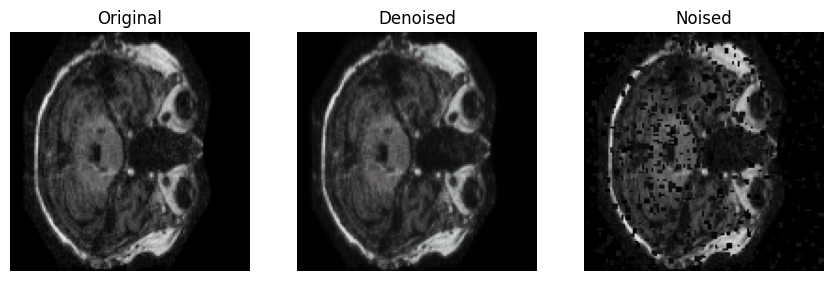

In [65]:
fig,ax=plt.subplots(1,3)
fig.set_size_inches(10.5, 7.5)
ax[0].imshow(single_test_original[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(single_unet_res_predicted[0])
ax[1].set_title('Denoised')
ax[1].axis('off')
ax[2].imshow(single_test_noise[0])
ax[2].set_title('Noised')
ax[2].axis('off')

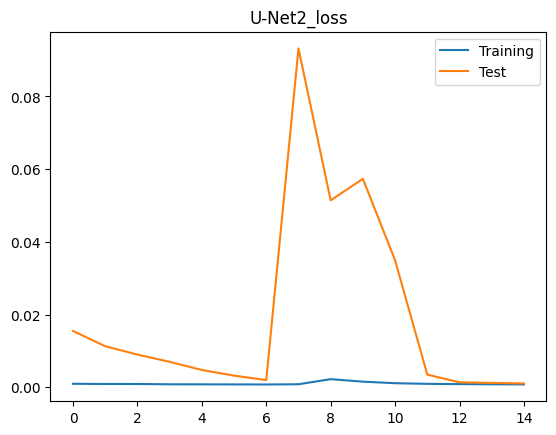

In [66]:
plt.plot(unet_res_history.history['loss'],label='Training')
plt.plot(unet_res_history.history['val_loss'],label='Test')
plt.title('U-Net2_loss')
plt.legend()
plt.show()

In [67]:
unet_res_predicted=unet_res.predict(data_test_processed)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step


In [70]:
unet_res_mse=mse_mean(test_original,unet_res_predicted)
unet_res_psnr=psnr_mean(test_original,unet_res_predicted)
unet_res_ssim=ssim_mean(test_original,unet_res_predicted)
print('MSE:',round(unet_res_mse,3))
print('PSNR:',round(unet_res_psnr,3))
print('SSIM:',round(unet_res_ssim,3))

MSE: 0.001
PSNR: 29.94
SSIM: 0.903
